In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_validate
import mlflow
import mlflow.sklearn

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from tqdm.auto import tqdm
import logging
import optuna
import itertools

import warnings
warnings.filterwarnings("ignore")

In [341]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer

In [359]:
def process_case_material(df):

    def extract_base(material):
        if material is None:
            return None 
        for base in ['Titanium', 'Platinum', 'Gold', 'Ceramic', 'Steel', 'Bronze', 'Aluminium']:
            if base in material:
                return base
        return None
    to_keep = ['Aluminium', 'Gold', 'Steel', 'Platinum', 'Titanium', 'Bronze', 'G-S Hybrid', 'Ceramic', 'Carbon-based']

    df['Case Material'] = df['Case Material'].fillna('').apply(lambda x: 'G-S Hybrid' if 'Gold' in x and 'Steel' in x else x)
    df['Case Material'] = df['Case Material'].apply(extract_base).fillna(df['Case Material'])
    df['Case Material'] = df['Case Material'].apply(lambda x: 'Carbon-based' if 'Carbo' in x or 'NORTEQ®' in x else None).fillna(df['Case Material'])
    df['Case Material'] = df['Case Material'].apply(lambda x: x if x in to_keep else "Others") 

    return df

def process_strap_material(df):
    
#         def impute_gold_enhanced_steel(material):
#             if 'Gold' in material and 'Steel' in material:
#                 return 'G-S Hybrid'
#             return material 

        def impute_(material):
            for mate in  ['Gold', 'Rubber', 'Leather', 'Titanium', 'Steel', 'Ceramic']:
                if mate in material:
                    return mate
            return None

        strap_mapping = {
            'Caoutchouc' : 'Rubber',
            'Sailcloth' : 'Fabric',
            'Nordura' : 'Fabric',
            'Silicon' : 'Silicone',
            'Calfskin' : 'Leather',
            'Cordura®' : 'Fabric',
            'Nato' : 'Nylon',
            'Cotton' : 'Fabric',
            'Textile' : 'Fabric',
            'Velvet' : 'Fabric',
            'Alcantara' : 'Fabric',
        }

        to_keep = ['Satin', 'Gold', 'Steel', 'Farbic', 'Leather', 'Rubber', 'Titanium', 'Nylon', 'Bronze', 'G-S Hybrid', 'Silicone', 'Ceramic']
        df['Strap Material'] = df['Strap Material'].apply(lambda x: 'G-S Hybrid' if 'Gold' in x and 'Steel' in x else x)
        df['Strap Material'] = df['Strap Material'].apply(impute_).fillna(df['Strap Material'])
        df['Strap Material'] = df['Strap Material'].map(strap_mapping).fillna(df['Strap Material'])
        df['Strap Material'] = df['Strap Material'].apply(lambda x: x if x in to_keep else "Others") 

        return df

def process_clasp_type(df):
    def process(type_):
        if 'Deploy' in type_ or 'Foldover' in type_:
            return 'Deployemnt'
        elif 'Folding' in type_:
            return 'Folding'
        elif 'Butterfly' in type_:
            return 'Butterfly'
        elif 'Hook-and-loop' in type_:
            return 'Hook-and-loop'
        elif 'Tang' in type_ or 'Pin' in type_ or 'Ardillon' in type_:
            return 'Tang'

    to_keep = ['Deployment', 'Folding', 'Butterfly', 'Hook-and-loop', 'Tang', 'Tudor “T-fit” Clasp', 'Winged Clasp']

    df['Clasp Type'] = df['Clasp Type'].fillna('').apply(process).fillna(df['Clasp Type'])
    df['Clasp Type'] = df['Clasp Type'].apply(lambda x: x if x in to_keep else "Others") 

    return df

def _impute_with_model(df, column):

    train_data = df[df[column].notnull()]
    test_data = df[df[column].isnull()]

    non_nan_columns = train_data.columns[train_data.notna().all()].tolist()
    numerical_features = train_data[non_nan_columns].select_dtypes(include=['float', 'int']).drop(columns=['price', column], errors='ignore').columns.tolist()
    categorical_features = train_data[non_nan_columns].select_dtypes(include=['object']).columns.tolist()

    encoder = OneHotEncoder(sparse_output=False, drop="first", handle_unknown='ignore')
    encoded_train = encoder.fit_transform(train_data[categorical_features])
    encoded_test = encoder.transform(test_data[categorical_features])

    X_train = pd.concat([
        train_data[numerical_features].reset_index(drop=True),
        pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_features))
    ], axis=1)

    X_test = pd.concat([
        test_data[numerical_features].reset_index(drop=True),
        pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_features))
    ], axis=1)

    y_train = train_data[column]

    X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    model = RandomForestRegressor(random_state=42, n_estimators=500)
    model.fit(X_train_split, y_train_split)

    print(f"Validation R^2 for {column} imputation: {model.score(X_valid_split, y_valid_split)}")

    test_data_predictions = model.predict(X_test)

    test_data.loc[:, column] = test_data_predictions

    df.loc[test_data.index, column] = test_data[column]

    return df

def clean_data(df):

    df = df.drop(columns=['name', 'Collection', 'Series', 'Calibre', 'Date', 'Chronograph', 'jewels', 'Lug Width', 'Diameter', 'Dial Type', 'Reference', 'Model No', 'EAN',
                'Case Back', 'Frequency', 'Base', 'Power Reserve (hours)', 'Dial Colour', 'Strap Colour', 'Buckle/Clasp Material'])
    
    brand_counts = df['Brand'].value_counts()
    popular_brands = brand_counts[brand_counts >= 25].index 
    df['Brand'] = df['Brand'].apply(lambda x: x if x in popular_brands else "Others")

    glass_counts = df['Glass Material'].value_counts()
    to_keep_glass = glass_counts[glass_counts >= 25].index 
    df['Glass Material'] = df['Glass Material'].apply(lambda x: x if x in to_keep_glass else "Others")

    
    df['Water Resistance (M)'] = df['Water Resistance (M)'].replace('Splash Resistant', 30).astype(float)
    df['Power Reserve'] = df['Power Reserve'].str.extract('(\d+)', expand=False).astype(float)
    df['Jewels'] = df['Jewels'].fillna(0)
    
    df['Bezel'] = df['Bezel'].fillna('No Bezel')
    df['Warranty Period'] = df['Warranty Period'].str.get(0).astype(float)

    df = df[(df['price'] < 15000000)]

    df = df.drop(df[df['Case Thickness'] > 200].index)
    df.loc[df['Water Resistance (M)'] == 6000, 'Water Resistance (M)'] = 600
    df.loc[df['Power Reserve'] > 5000, 'Power Reserve'] /= 1000
    
    return df

def feature_engineer(df):

    precious_stones_df = pd.DataFrame()
    parts = ["Case", "Dial", "Bracelet", "Crown", "Clasp", "Bezel", "Lugs", "Buckle"]
    for part in parts:
        precious_stones_df[f"precious_stone_on_{part}"] = df['Precious Stone'].fillna('').apply(lambda x: 1 if part in str(x) else 0)
    
    string = ', '.join(list(df['Features'].dropna().unique()))
    features = list(set(string.split(', ')))
    features_df = pd.DataFrame()
    for feature in features:
        features_df[f"feature_{feature}"] = df['Features'].fillna('').apply(lambda x: 1 if feature in x else 0)        
    features_df = features_df.loc[:, features_df.apply(lambda col: col.sum() >= 10)]
    
    luminosity_df = pd.DataFrame()
    parts = ['Hands', 'Hour', 'Bezel', 'Dial']
    for part in parts:
        luminosity_df[f"luminosity_on_{part}"] = df['Luminosity'].fillna('').apply(lambda x: 1 if part in x else 0)
        
    df = df.drop(columns=['Luminosity', 'Features', 'Precious Stone'])
    
    df['Case Material Coating'] = df['Case Material'].fillna('').apply(lambda material: next((coating for coating in ['DLC', 'PVD', 'CVD'] if coating in material), None))
    df['Case Material Coating'] = df['Case Material Coating'].fillna('None')
    
    df = pd.concat([df, features_df, luminosity_df,precious_stones_df], axis=1)
    
    return df

def clean_material_values(df):
    df = process_case_material(df)
    df = process_strap_material(df)
    df = process_clasp_type(df)
    return df

def remove_unnecessary_col(df):

    features = [col for col in df.columns if 'feature' in col]
    features_df = df[features + ['price']]
    correlation_matrix = features_df.corr()
    price_corr = correlation_matrix['price']
    selected_features = price_corr[price_corr.abs() >= 0.1].index
    features_df = features_df[selected_features]
    
    df = pd.concat([df.drop(columns=features), features_df.drop(columns=['price'], axis=1)], axis=1)
    
    return df

def impute_missing_vals(df):
    df = _impute_with_model(df, 'Case Thickness')
    df = _impute_with_model(df, 'Power Reserve')
    
    knn_imputer = KNNImputer(n_neighbors=1)
    df[['Power Reserve', 'Frequency (bph)']] = knn_imputer.fit_transform(df[['Power Reserve', 'Frequency (bph)']])
    
    df.loc[df['Movement'].isnull(), 'Movement'] = 'Quartz'
    df.loc[df['Water Resistance (M)'].isna(), 'Water Resistance (M)'] = 30.0
    
    df = df.drop(columns=['Hands', 'Indexes', 'Display'])
    return df


In [345]:
df = pd.read_csv("data/raw_data.csv")
df = clean_data(df)
df = feature_engineer(df)
df = clean_material_values(df)
df = df.drop_duplicates()

df = remove_unnecessary_col(df)
df = df.drop_duplicates()
df = impute_missing_vals(df)
df = df.drop_duplicates()

Validation R^2 for Case Thickness imputation: 0.829894186165183
Validation R^2 for Power Reserve imputation: 0.8909427748014388


In [360]:
d = pd.read_csv("processed_data.csv")

In [362]:
d

,price,Brand,Movement,Case Size,Case Thickness,Case Shape,Case Material,Glass Material,Strap Material,Clasp Type,...,feature_Year,feature_Moon Phase,feature_Power Reserve Indicator,feature_Jumping Hours,feature_Tourbillon,feature_Small Seconds,feature_Month,feature_Retrograde,feature_Dual Time,feature_Date
0,1580000,Girard-Perregaux,Automatic,38.0,10.00000,Octagon,Steel,Sapphire Crystal,Steel,Folding,...,0,0,0,0,0,0,0,0,0,1
1,2000000,Girard-Perregaux,Automatic,38.0,10.00000,Octagon,Steel,Sapphire Crystal,Steel,Folding,...,0,0,0,0,0,0,0,0,0,1
2,890000,Zenith,Automatic,41.0,11.60000,Octagon,Steel,Sapphire Crystal,Steel,Folding,...,0,0,0,0,0,1,0,0,0,1
3,1190000,Zenith,Automatic,36.0,10.35000,Octagon,Steel,Sapphire Crystal,Steel,Folding,...,0,0,0,0,0,0,0,0,0,1
4,623800,Omega,Quartz,36.0,9.59826,Round,G-S Hybrid,Sapphire Crystal,G-S Hybrid,Folding,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3547,573000,IWC,Automatic,40.0,10.80000,Round,Steel,Sapphire Crystal,Steel,Folding,...,0,0,0,0,0,0,0,0,0,1
3548,2300000,Jacob & Co.,Manual Winding,44.0,13.50000,Round,Titanium,Sapphire Crystal,Rubber,Others,...,0,0,0,0,0,0,0,0,0,0
3549,368000,Longines,Automatic,42.0,14.20000,Round,Steel,Sapphire Crystal,Steel,Folding,...,0,1,0,0,0,1,1,0,0,1
3550,705000,IWC,Automatic,43.0,14.80000,Round,Steel,Sapphire Crystal,Leather,Tang,...,0,0,0,0,0,1,0,0,0,1


In [372]:
d[['feature_Triple Time-zone', 'feature_Flying Tourbillon']] = df[['feature_Triple Time-zone', 'feature_Flying Tourbillon']]

In [373]:
d

,price,Brand,Movement,Case Size,Case Thickness,Case Shape,Case Material,Glass Material,Strap Material,Clasp Type,...,feature_Power Reserve Indicator,feature_Jumping Hours,feature_Tourbillon,feature_Small Seconds,feature_Month,feature_Retrograde,feature_Dual Time,feature_Date,feature_Triple Time-zone,feature_Flying Tourbillon
0,1580000,Girard-Perregaux,Automatic,38.0,10.00000,Octagon,Steel,Sapphire Crystal,Steel,Folding,...,0,0,0,0,0,0,0,1,0.0,0.0
1,2000000,Girard-Perregaux,Automatic,38.0,10.00000,Octagon,Steel,Sapphire Crystal,Steel,Folding,...,0,0,0,0,0,0,0,1,0.0,0.0
2,890000,Zenith,Automatic,41.0,11.60000,Octagon,Steel,Sapphire Crystal,Steel,Folding,...,0,0,0,1,0,0,0,1,0.0,0.0
3,1190000,Zenith,Automatic,36.0,10.35000,Octagon,Steel,Sapphire Crystal,Steel,Folding,...,0,0,0,0,0,0,0,1,0.0,0.0
4,623800,Omega,Quartz,36.0,9.59826,Round,G-S Hybrid,Sapphire Crystal,G-S Hybrid,Folding,...,0,0,0,0,0,0,0,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3547,573000,IWC,Automatic,40.0,10.80000,Round,Steel,Sapphire Crystal,Steel,Folding,...,0,0,0,0,0,0,0,1,0.0,0.0
3548,2300000,Jacob & Co.,Manual Winding,44.0,13.50000,Round,Titanium,Sapphire Crystal,Rubber,Others,...,0,0,0,0,0,0,0,0,0.0,0.0
3549,368000,Longines,Automatic,42.0,14.20000,Round,Steel,Sapphire Crystal,Steel,Folding,...,0,0,0,1,1,0,0,1,0.0,0.0
3550,705000,IWC,Automatic,43.0,14.80000,Round,Steel,Sapphire Crystal,Leather,Tang,...,0,0,0,1,0,0,0,1,0.0,0.0


In [375]:
# X = d.drop['price']

In [387]:
numerical_cols = ['Case Size', 'Case Thickness', 'Power Reserve', 'Frequency (bph)', 'Jewels', 'Water Resistance (M)', 'Warranty Period']
categorical_cols = d.drop(columns=['Case Size', 'Case Thickness', 'Power Reserve', 'Frequency (bph)', 'Jewels', 'Water Resistance (M)', 'Warranty Period']).columns.tolist()

luminosity = []

for col in d.columns:
    if 'luminosity' in col:
        luminosity.append(col)

In [399]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [400]:
params = {
        'iterations': 1500,
        'learning_rate':  0.1642852035875127,
        'depth': 4,
        'l2_leaf_reg': 4,
        'rsm': 0.8263126640848959,
        'random_strength': 0.658651292068157,
        'bagging_temperature': 0.12208059366638693,
        'border_count': 64,
        'verbose':0,
        'loss_function': 'RMSE'
    }

In [401]:
X_train = train.drop(columns = ['price'])
y_train = np.log1p(train['price'])

X_test = test.drop(columns = ['price'])
y_test = np.log1p(test['price'])

binary_cat_cols = [
    col for col in X_train.columns
    if X_train[col].nunique() == 2
]

multi_cat_cols = X_train.drop(columns=binary_cat_cols + numerical_cols).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numerical_cols),
        ('binary_cols', 'passthrough', binary_cat_cols),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(**params))
])

In [395]:
from tqdm import tqdm

In [402]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

y_test_orig = np.expm1(y_test)  
y_pred_orig = np.expm1(y_pred)  

mse = mean_squared_error(y_test_orig, y_pred_orig)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

mae = mean_absolute_error(y_test_orig, y_pred_orig)
print("MAE:", mae)

r2 = r2_score(y_test_orig, y_pred_orig)
print("r2:", r2)

MSE: 187585685322.34827
RMSE: 433111.63147893903
MAE: 135749.02635128755
r2: 0.8770416921142568


In [358]:
len(X_train.columns)

44

In [ ]:
MSE: 152809806279.38046
RMSE: 390908.9488351226
MAE: 129053.01147585381
r2: 0.874049688395323

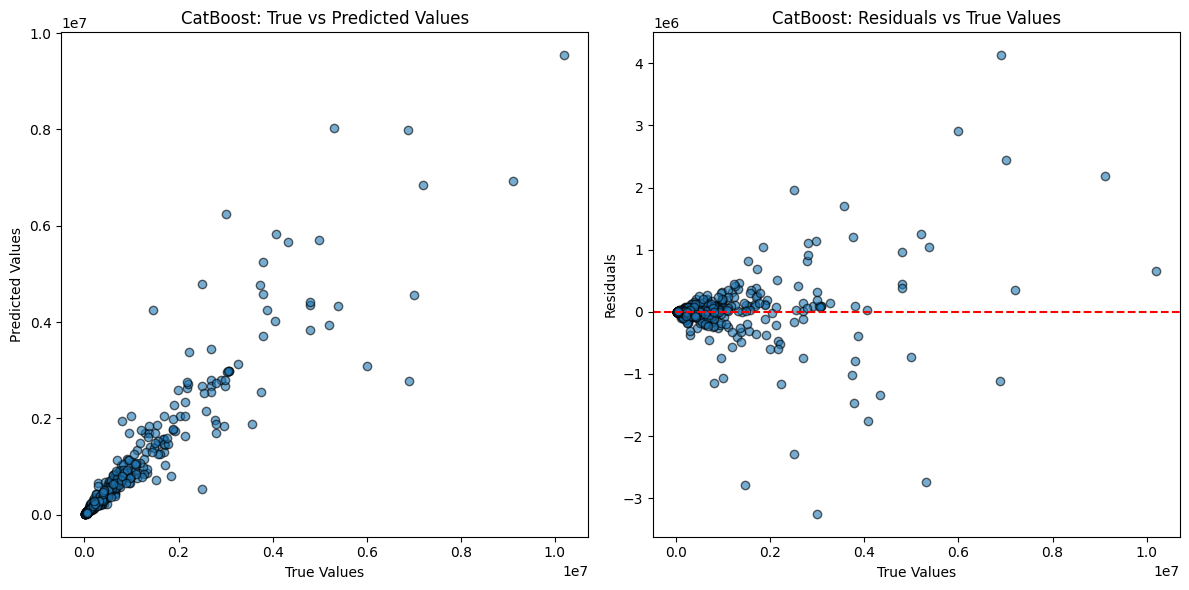

In [354]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

residuals = y_test_orig - y_pred_orig

ax1 = axes[0]
ax1.scatter(y_test_orig, y_pred_orig, alpha=0.6, edgecolor='k')
ax1.set_xlabel("True Values")
ax1.set_ylabel("Predicted Values")
ax1.set_title(f"CatBoost: True vs Predicted Values")

ax2 = axes[1]
ax2.scatter(y_test_orig, residuals, alpha=0.6, edgecolor='k')
ax2.axhline(0, color='red', linestyle='--')
ax2.set_xlabel("True Values")
ax2.set_ylabel("Residuals")
ax2.set_title(f"CatBoost: Residuals vs True Values")

plt.tight_layout()